# Self-supervised learning with fastai

Inspired by [Ayush Thakur's work](https://www.kaggle.com/ayuraj/v2-self-supervised-pretraining-with-swav?scriptVersionId=59516445), I started exploring more about SwAV. The results in the [paper](https://arxiv.org/abs/2006.09882) were quite impressive. Hence, I decided to implement it.

Lucky for me, I found a pytorch implementation. Also, it used fastai. This was like a dream come true. Fastai is my comfort zone. You can find more about the [implementation here](https://keremturgutlu.github.io/self_supervised/). I will highly recommend checking out the documentation. Not just SwAV, the repository has fastai implementations of other state-of-the-art algorithms as well.

I followed [this tutorial](https://keremturgutlu.github.io/self_supervised/04%20-%20training_swav_iwang.html) for creating this notebook that you are reading now. So, if something looks off or doesn't make sense, then please refer the original tutorial.

Lets get started . . .

### Installation & imports

In [1]:
!pip install self-supervised -Uq

In [2]:
from fastai.vision.all import *

from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.swav import *

from sklearn.model_selection import StratifiedKFold
import torchvision.models as models
from cuml.neighbors import NearestNeighbors

### Reading Data

In [3]:
df = pd.read_csv('../input/shopee-product-matching/train.csv')
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


To train the model, we will also need a validation set. I will use simple `StratifiedKFold` technique to split my data into train & validation set.

In [4]:
sk_fold = StratifiedKFold(5)
df['is_valid'] = False
for i, (trn_idx, val_idx) in enumerate(sk_fold.split(df, df.label_group)):
    df.loc[val_idx, 'is_valid'] = True
    break
    
df.groupby('is_valid').label_group.value_counts()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


is_valid  label_group
False     159351600      41
          562358068      41
          1141798720     41
          1163569239     41
          3113678103     41
                         ..
True      4290195299      1
          4290248491      1
          4291905065      1
          4292006141      1
          4294197112      1
Name: label_group, Length: 16949, dtype: int64

As per the warning, there are some label groups with less than 5 posting. lets see how many such label group we have . . . 

In [5]:
sum(df.label_group.value_counts() < 5)

9620

There are 9620 `label_group` with less than 5 postings. Quite a lot, huh! (lets handle it in version-2).

### Dataloaders

For now, lets create some helper functions to create dataloaders.

In [6]:
def get_x(x): return '../input/shopee-product-matching/train_images/' + x['image']

def get_dls(size, bs, workers=None):
    path = Path('../input/shopee-product-matching/train_images/')
    
    db = DataBlock(blocks = (ImageBlock(), CategoryBlock()),
              get_x = get_x, get_y=ColReader('label_group'),
              splitter=ColSplitter(),
              item_tfms=RandomResizedCrop(size, min_scale=1.))
    dls = db.dataloaders(df, bs=bs, num_workers=workers)
    return dls

Lets create our dataloaders . . . 

In [7]:
bs, resize, size = 24, 256, 224
dls = get_dls(resize, bs)

### Model & Callbacks

Finally, lets initialize our model & SwAV callbacks

In [8]:
## Model
arch = "resnet50"
encoder = create_encoder(arch, pretrained=True, n_in=3)
model = create_swav_model(encoder)

## SwAV callback
K = bs*2**4
aug_pipelines = get_swav_aug_pipelines(num_crops=[2, 6],
                                       crop_sizes=[size,int(3/4*size)], 
                                       min_scales=[0.25, 0.20],
                                       max_scales=[1.00, 0.35],
                                       rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False)
cbs=[SWAV(aug_pipelines, crop_assgn_ids=[0,1], K=K, queue_start_pct=0.5, temp=0.1)]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Great, we have our data, model, & also the callbacks. Fastai has this amazing class called `Learner` which put everything together for training.

In [9]:
learn = Learner(dls, model, cbs=cbs)

Before we actually training the model, lets look at some of the samples. 

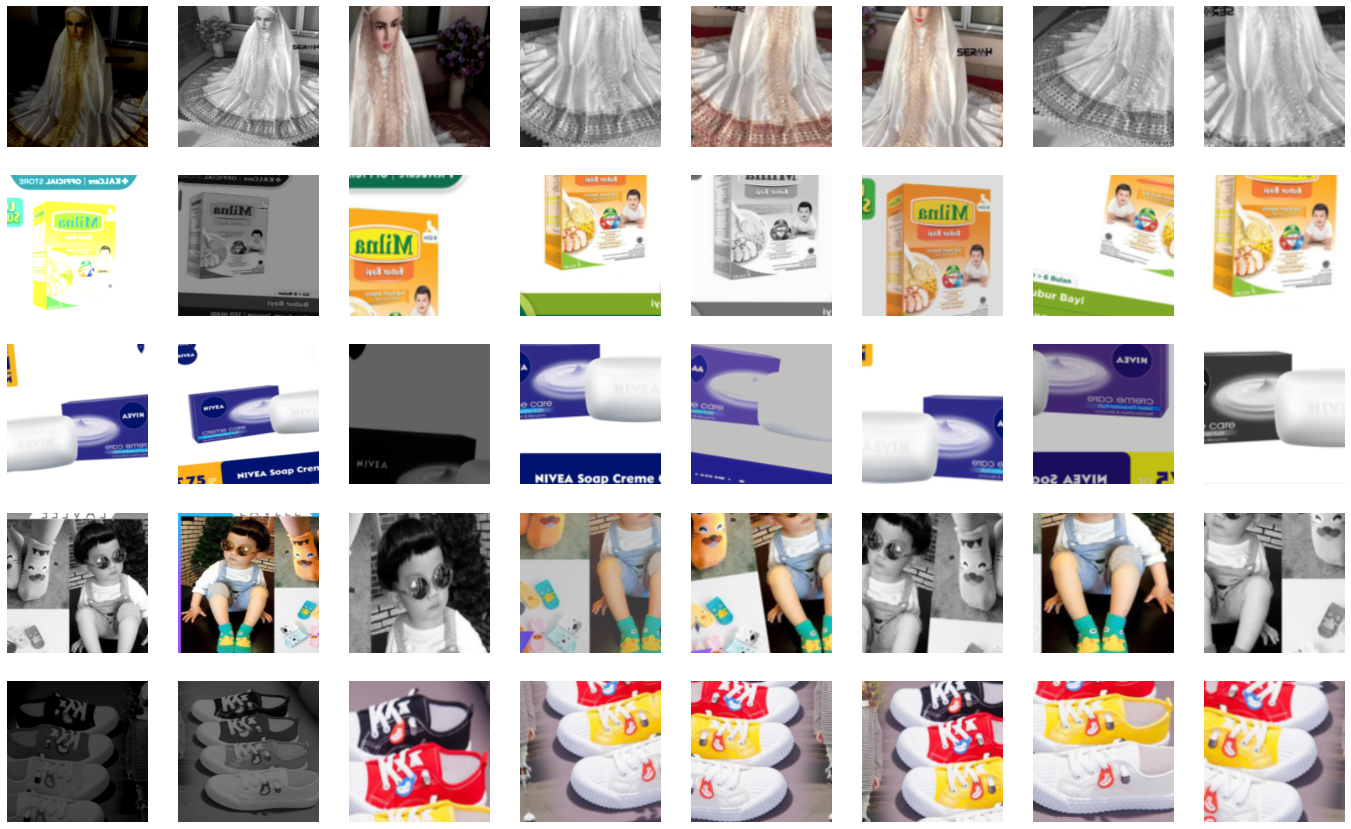

In [10]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show(n=5);

### Training 

Time to train the model . . . 

In [11]:
lr, wd = 1e-2, 1e-2
epochs = 5 # try using 40 or 50
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,7.971663,7.977367,20:31
1,7.757523,7.968008,20:09
2,7.586119,7.429262,20:03
3,7.386775,7.340018,20:03
4,7.277427,7.224354,20:06


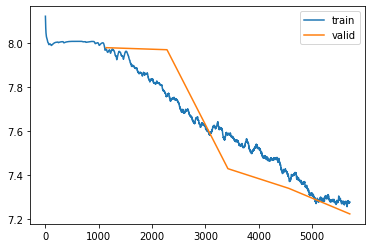

In [12]:
save_name = f'swav_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')
learn.recorder.plot_loss()

This notebook is only intended for learning. To get better score, try using different model architecture, bigger image size, etc.

I can find the inference notebook, [here](https://www.kaggle.com/ankursingh12/shopee-swav-inference)

Hope you enjoyed reading this notebook. If yes, then please consider **upvoting**!